In [20]:
import os
import shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from invert import invert_ebb, load_source_time_series
from simulate import run_current_density_simulation
from laminar import model_comparison
from matplotlib import colors
from scipy.stats import ttest_rel

In [21]:
sim_vertex=420
freq=20
dipole_moment=10
sim_patch_size=5
SNR=-5
n_layers=11
layers = np.linspace(1, 0, n_layers)

data_dir='./test_data'
out_dir='./test_output'
tmp_dir='/scratch/bonaiuto/simulated_data/roi'
subj_id='sub-104'
ses_id='ses-01'
# Subject fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# T1
mri_fname = os.path.join(data_dir,'spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')

mesh_fname = os.path.join(out_dir, subj_id, 'multilayer.11.ds.link_vector.gii')

## Create intermediate surfaces if needed
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join(out_dir, subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'white.ds.link_vector.gii'))

# Data file to base simulations on
data_file=os.path.join(data_dir, 'processed', subj_id, ses_id, 'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')

patch_size=5
n_temp_modes = 4

mesh=nib.load(mesh_fname)
verts_per_surf=mesh.darrays[0].data.shape[0]/n_layers


In [3]:
# Invert the subject's data. This step only has to be done once
[base_fname,_,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, data_file, n_layers, 
                            patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


Text(0, 0.5, 'Amplitude (nAm)')

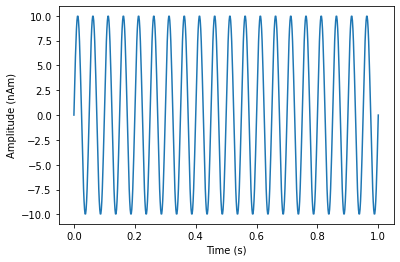

In [22]:
time=np.linspace(0,1,601)
sim_signal=np.sin(time*freq*2*np.pi).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [5]:
# Simulate on pial surface
pial_vertex=sim_vertex
prefix=f'sim_{sim_vertex}_pial.'
pial_sim_fname=run_current_density_simulation(base_fname, prefix, pial_vertex, sim_signal, dipole_moment, 
                                             sim_patch_size, SNR)    

In [6]:
[inv_pial_sim_fname,_,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, pial_sim_fname, n_layers, 
                                    foi=[freq-5, freq+5], patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [7]:
pial_layer_ts=load_source_time_series(inv_pial_sim_fname, inv_pial_sim_fname, vertices=np.arange(verts_per_surf))
pial_layer_ts=np.array(pial_layer_ts)
white_layer_ts=load_source_time_series(inv_pial_sim_fname, inv_pial_sim_fname, vertices=(n_layers-1)*verts_per_surf+np.arange(verts_per_surf))
white_layer_ts=np.array(white_layer_ts)

In [8]:
pial_var=np.var(pial_layer_ts,axis=1)
white_var=np.var(white_layer_ts,axis=1)
roi=np.where((pial_var>=np.percentile(pial_var,99)) & (white_var>=np.percentile(white_var,99)))[0]
t_statistic, p_value = ttest_rel(pial_var[roi], white_var[roi])
print(f't({len(roi)-1})={t_statistic}, p={p_value}')

t(367)=2.1999608401837034, p=0.028432432265890525


In [9]:
# Simulate on white matter surface
white_vertex=(n_layers-1)*verts_per_surf+sim_vertex
prefix=f'sim_{sim_vertex}_white.'
white_sim_fname=run_current_density_simulation(base_fname, prefix, white_vertex, sim_signal, dipole_moment, 
                                               sim_patch_size, SNR) 

In [10]:
[inv_white_sim_fname,_,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, white_sim_fname, n_layers, 
                                     foi=[freq-5, freq+5], patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [11]:
pial_layer_ts=load_source_time_series(inv_white_sim_fname, inv_white_sim_fname, vertices=np.arange(verts_per_surf))
pial_layer_ts=np.array(pial_layer_ts)
white_layer_ts=load_source_time_series(inv_white_sim_fname, inv_white_sim_fname, vertices=(n_layers-1)*verts_per_surf+np.arange(verts_per_surf))
white_layer_ts=np.array(white_layer_ts)

In [12]:
pial_var=np.var(pial_layer_ts,axis=1)
white_var=np.var(white_layer_ts,axis=1)
roi=np.where((pial_var>=np.percentile(pial_var,99.9)) & (white_var>=np.percentile(white_var,99.9)))[0]
t_statistic, p_value = ttest_rel(pial_var[roi], white_var[roi])
print(f't({len(roi)-1})={t_statistic}, p={p_value}')

t(42)=-1.8594682801398255, p=0.0699752386475224


In [13]:
all_layerPow=[]
for l in range(len(layers)):
    print(f'Simulating in layer {l}')
    l_vertex=l*verts_per_surf+sim_vertex
    prefix=f'sim_{sim_vertex}_l.'
    l_sim_fname=run_current_density_simulation(base_fname, prefix, l_vertex, sim_signal, dipole_moment, 
                                               sim_patch_size, SNR) 
    [inv_l_sim_fname,_,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, l_sim_fname, n_layers, 
                                     foi=[freq-5, freq+5], patch_size=patch_size, n_temp_modes=n_temp_modes)
    
    layer_ts=load_source_time_series(inv_l_sim_fname, inv_l_sim_fname)
    layer_ts=np.array(layer_ts)
    
    pial_pow=np.var(layer_ts[0:int(verts_per_surf),:],axis=1)
    roi=np.where(pial_pow>=np.percentile(pial_pow,99.9))[0]
    for l in range(1,len(layers)):
        layer_pow=np.var(layer_ts[l*int(verts_per_surf):(l+1)*int(verts_per_surf),:],axis=1)
        roi=np.intersect1d(roi, np.where(layer_pow>=np.percentile(layer_pow,99.9))[0])

    roi_pow=np.zeros((n_layers, len(roi)))
    for l in range(len(layers)):
        roi_pow[l,:]=np.var(layer_ts[l*int(verts_per_surf)+roi,:],axis=1)

    all_layerPow.append(np.mean(roi_pow,axis=1))
all_layerPow=np.array(all_layerPow)

Simulating in layer 0
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 1
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 2
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 3
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 4
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 5
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 6
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 7
Smoothing ./test_output/su

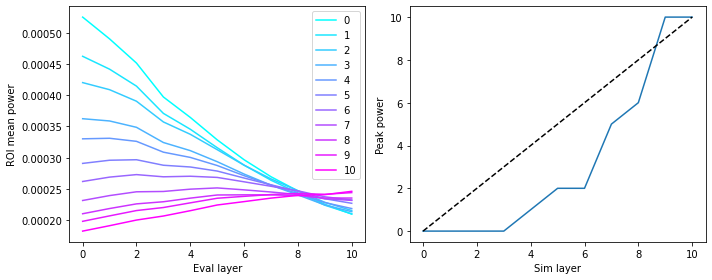

In [14]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    layerPow=all_layerPow[l,:]
    plt.plot(layerPow, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('ROI mean power')

plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerPow=all_layerPow[l,:]
    pk=np.argmax(layerPow)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak power')
plt.tight_layout()

In [19]:
# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)